# CSE 627 - Project Report 1 - Animal Shelter Outcomes
By: Meisam Amjad, Shangye Chen, and John Shaver
## Abstract
This project involved participating in an online machine learning competition, specifically through the website Kaggle. For our project we chose to participate in the Animal Shelter Outcomes Competition. (Available here: __[Animal Shelter Outcomes Competition Page](http://www.kaggle.com/c/Shelter-animal-outcomes)__ *External Link*) This competition provides both train and test data, and wants the probability of the various outcomes for a given animal. The following report contains our approach to this problem.

##  Introduction
To start working on this problem we have to do two things first. One, import various machine learning and other libraries

In [1]:
# This is a magic procedural interface to the matplotlib, also numpy
%pylab notebook
# Python Data Analysis Library
import pandas as pd
# statistical data visualization. For Plotting featurs based on the count of them            
import seaborn as sns

from sklearn.preprocessing import Imputer, LabelEncoder                   

from sklearn.feature_extraction import DictVectorizer as DV

from sklearn.svm import SVC

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix, classification_report

Populating the interactive namespace from numpy and matplotlib


Second we need to understand what the data we have looks like. So, we load both the training and the test data, followed by printing out their respective data:

In [2]:
train_data = pd.read_csv('train.csv')        # Loading the database
test_data  = pd.read_csv('test.csv')         # Loading the database
test_data.head(5)                            # The 10 first rows of the test_data

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


In [3]:
train_data.head(5)                            # The 10 first rows of the train_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


As we can see the train_data has 10 features and the test_data has only 8 features, which is due to the known *outcome* and *outcome subbtype* features in the test data. The other 8 features describe various information about each animal. 

Since we would like to predict probability of an animal to have a given outcome type, we should investigate how this feature looks. The following code displays a histogram of the various outcome types.

<IPython.core.display.Javascript object>


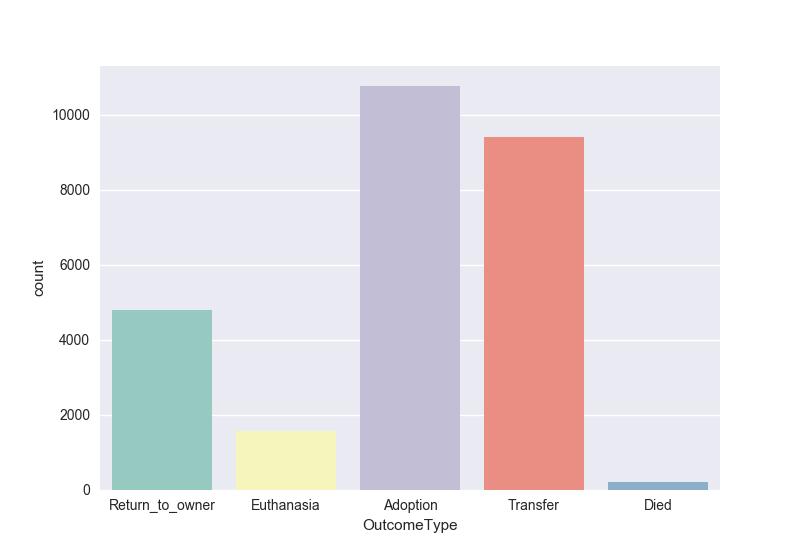

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64


In [4]:
figure()                                               # Openning a new figure 
sns.countplot(train_data.OutcomeType, palette='Set3'); # Plot the data
print train_data.OutcomeType.value_counts()            # Showing the number of each element

We can see that the majority of our test data will be on Adoptions and Transfers, while the remaining options of Return_to_owner, Euthanasia, and Died take up about 20% of the data. Now we will investigate the features that we willl use to determine these outcomes, but first we will encode the outcome types as numbers to remove strings from our data set. 

In [5]:
outcomes = train_data.OutcomeType                     # First keep the outcomes
print (outcomes.unique())                             # Displaing the outcomes
le = LabelEncoder()                                   # Encode labels with value between 0 and n_classes-1
Y_train = le.fit_transform(train_data['OutcomeType']) # Fit label encoder and return encoded labels
set(Y_train)                                          # Showing unique elements of the outcomes

['Return_to_owner' 'Euthanasia' 'Adoption' 'Transfer' 'Died']


{0, 1, 2, 3, 4}

## Data Manipulation
Now that we know how our data looks we can inspect each individual feature and determine how to pass the informatino to the machine learning classifier. In this case, we would like to convert the features into more grouped data atributes. While we can generate the same amount of features as the original input, we can also extrapolate information from the features and create additional features from it.


### Name Feature
To start off simply we will look at the *Name* feature. The following code block lists the numbber of samples with this property, then prints out a portion of the list of names.  

In [6]:
print ('number of values = ', 
       len(train_data.Name))                       # Print the number of values
print(train_data.Name.head(10))                    # Print value_counts()

('number of values = ', 26729)
0    Hambone
1      Emily
2     Pearce
3        NaN
4        NaN
5       Elsa
6      Jimmy
7        NaN
8       Lucy
9        NaN
Name: Name, dtype: object


From this we can se there are a variety of normal pet names, along with $NaN$ values. Thus we can make a clear divide between animals with and without<br>($NaN$) a name, easily represented by a boolean value. The following code blok defines a function to determine wether or not a given Name property is or is not a name. It also creats a new feature in the training data *Name_Status* which contains either 1 or 0, for having a name or $NaN$.

In [7]:
def getNameStatus(s):
    ''' This method is used to determine the Name status of the Animal.
        Returns 1 if the animal has a name. Otherwise returns 0 .
    '''
    s = str(s)
    if s != 'nan': return 1
    return 0
train_data['Name_Status'] = train_data.Name.apply (getNameStatus) # Apply the method for the feature 'Name_Status'

The next code block plots two histograms depicting how our training data is divided upon this atribbute.

<IPython.core.display.Javascript object>


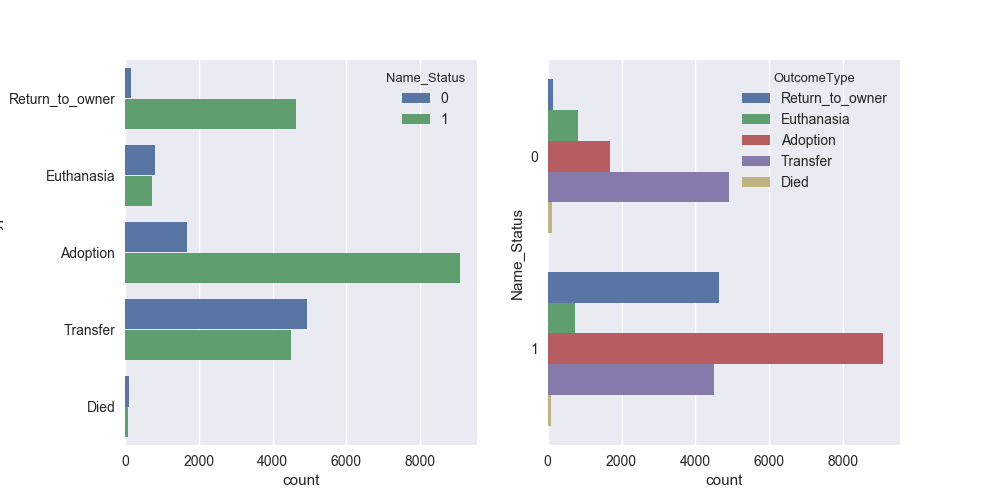

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))                              # Defining 2 plots
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'Name_Status', ax = ax1); # plot 1
sns.countplot(data = train_data, y = 'Name_Status',hue = 'OutcomeType', ax = ax2); # plot 2

We can see that while there are more animals with names then without, we can also see that the name atribute severly affects adoption and return to owner rate. Thus creating this attribute in this matter should help provide the calssification algorithm to perform better. Lastly, we will apply this same method on the test data, done in the next code segment.

In [9]:
test_data['Name_Status'] = test_data.Name.apply (getNameStatus) # Apply the method for the feature 'Name_Status'

### DateTime Feature
The next feature we will look at is $DateTime$. The following code block looks at the unique contents of this feture.


In [10]:
print ('number of unique elements = ', len(train_data.DateTime.unique()))
train_data.DateTime.unique()                       # Showing all unique values

('number of unique elements = ', 22918)


array(['2014-02-12 18:22:00', '2013-10-13 12:44:00', '2015-01-31 12:28:00',
       ..., '2015-05-14 11:56:00', '2015-03-09 13:33:00',
       '2014-04-27 12:22:00'], dtype=object)

We can see that within this information we not only have the time of day but also the year, month, and day. The following code block defines functins for determining the day and time of day an outcome occurs. The time of day is grouped into five regions, Morning, Noon, Afternoon, Evening, and Night to minimze the size of uniqe values for the *TIME* feature. The block also then creates these two features in the training data.

In [11]:
allTimes = ['Morning', 'Noon', 'Afternoon', 'Evening', 'Night']

def getDay(t):
    t = pd.to_datetime(t)
    if t.weekday() == 0: return 'Monday'
    if t.weekday() == 1: return 'Tuesday'
    if t.weekday() == 2: return 'Wednesday'
    if t.weekday() == 3: return 'Thursday'
    if t.weekday() == 4: return 'Friday'
    if t.weekday() == 5: return 'Saturday'
    if t.weekday() == 6: return 'Sunday'
    return 'Unknown'

def getDayNum(t):
    t = pd.to_datetime(t)
    return t.weekday()

def getTime(t):
    t = pd.to_datetime(t)
    if (t.time() > datetime.time(5,0))   & (t.time() <= datetime.time(12,0)) : return 'Morning'
    if (t.time() > datetime.time(12,0))  & (t.time() <= datetime.time(13,0)) : return 'Noon'
    if (t.time() > datetime.time(13,0))  & (t.time() <= datetime.time(17,0)) : return 'Afternoon'
    if (t.time() > datetime.time(17,0))  & (t.time() <= datetime.time(21,0)) : return 'Evening'
    return 'Night'


train_data['Days'] = train_data.DateTime.apply(getDay)
train_data['Time'] = train_data.DateTime.apply(getTime)

The following code segments plots the histogram of the output types, with the data split based upon each feature.

<IPython.core.display.Javascript object>


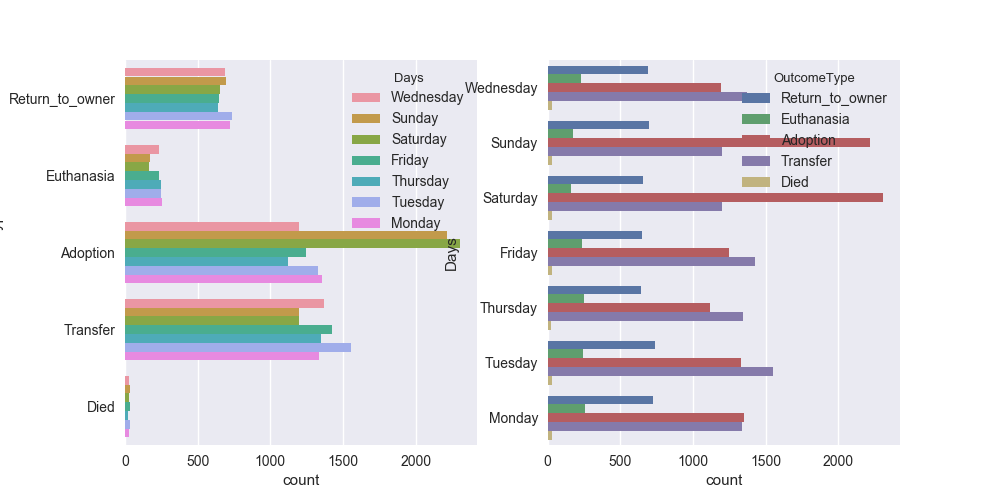

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))                       # Defining 2 plots
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'Days', ax = ax1); # plot 1
sns.countplot(data = train_data, y = 'Days',hue = 'OutcomeType', ax = ax2); # plot 2

<IPython.core.display.Javascript object>


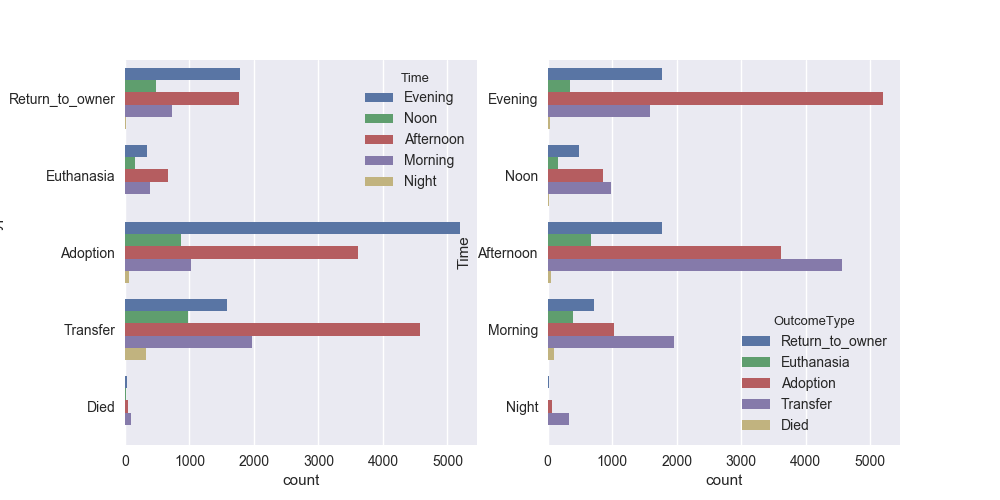

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))                       # Defining 2 plots
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'Time', ax = ax1); # plot 1
sns.countplot(data = train_data, y = 'Time',hue = 'OutcomeType', ax = ax2); # plot 2

From these histograms we can see that the day of the week seems to only effect adoption rates with an increases on saturday and sunday. While the second histogram shows that at evenings and afternoon times adoption and return to owner rates are much more likely. Also, transfers seem to mainly occur during the afternoon , and animals that died seem to occur most often in the morning. 

We now convert these new features into numerical input for the training data, which is done in the following code sections.

In [15]:
print ('start vectorizing...')               # Showing message at the begining of vectorization.                
for time in allTimes:
        train_data[time] = pd.get_dummies(train_data['Time'])[time]
train_data['Days'] = train_data.DateTime.apply(getDayNum)
print ('Done!...')                           # Showing message at the end.

start vectorizing...
Done!...


Lastly we apply the above methods to the test data as well.

In [12]:
test_data['Days'] = train_data.DateTime.apply(getDay)
test_data['Time'] = train_data.DateTime.apply(getTime)

In [16]:
print ('start vectorizing...')               # Showing message at the begining of vectorization.                
for time in allTimes:
        test_data[time] = pd.get_dummies(test_data['Time'])[time]
test_data['Days'] = test_data.DateTime.apply(getDayNum)
print ('Done!...')                           # Showing message at the end.

start vectorizing...
Done!...


### Animal Types
The next feature we will look at is $Animal Types$. The following code block plots a histogram this feature.

<IPython.core.display.Javascript object>


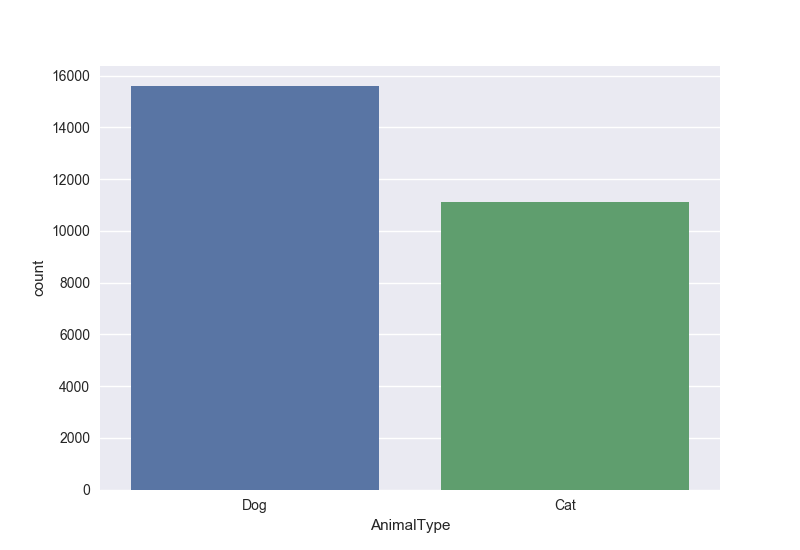

Dog    15595
Cat    11134
Name: AnimalType, dtype: int64

In [17]:
figure()                              # Openning a new figure 
sns.countplot(train_data.AnimalType); # Plot the data
train_data.AnimalType.value_counts()  # Showing all values + how many of them

So we are dealing with only 2 different animals, cats and dogs. We now will seperate this feature into *Cat* and *Dog* features, then we plot histograms of the *Cat* and *Dog* features based upon their outcome types. 

In [18]:
train_data['Cat'] = pd.get_dummies(train_data.AnimalType)['Cat']      # Vectorizing the feature Cat
train_data['Dog'] = pd.get_dummies(train_data.AnimalType)['Dog']      # Vectorizing the feature Dog

<IPython.core.display.Javascript object>


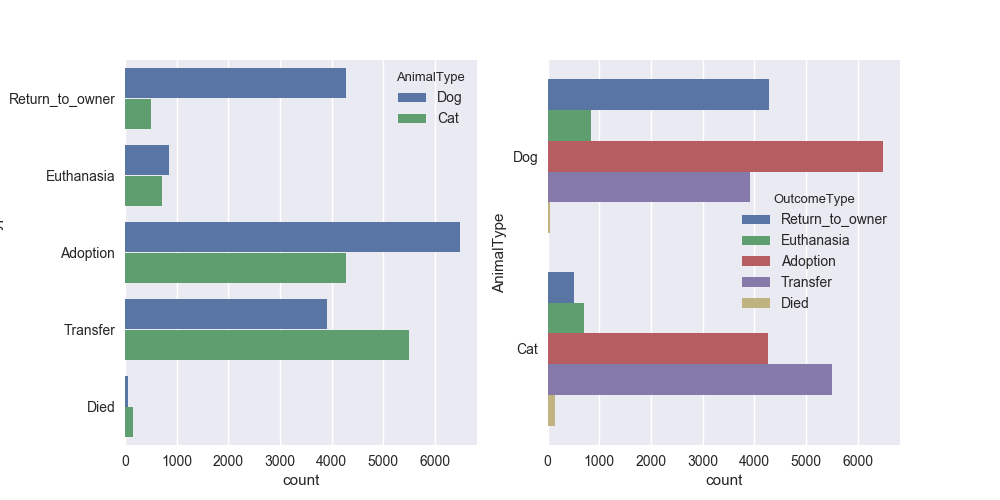

In [19]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))                             # Defining 2 plots
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'AnimalType', ax = ax1); # plot 1
sns.countplot(data = train_data, y = 'AnimalType',hue = 'OutcomeType', ax = ax2); # plot 2

From the above figures we can see that dogs are more likely than cats to be adopted. As well as, dogs are much more likely to return to owner. Contrarily, for cats they are more likely to be transfer or to have died. Based upon this we believe this feature should help us separate our data even better.

Before moving to the next feature, we will apply this to our test data as well.

In [20]:
test_data['Cat'] = pd.get_dummies(test_data.AnimalType)['Cat']      # Vectorizing the feature Cat
test_data['Dog'] = pd.get_dummies(test_data.AnimalType)['Dog']      # Vectorizing the feature Dog

### Sex Upon Outcomes
Now we will look at the feature of $Sex Upon Outcomes$. The following code block plots a histogram this feature.

<IPython.core.display.Javascript object>


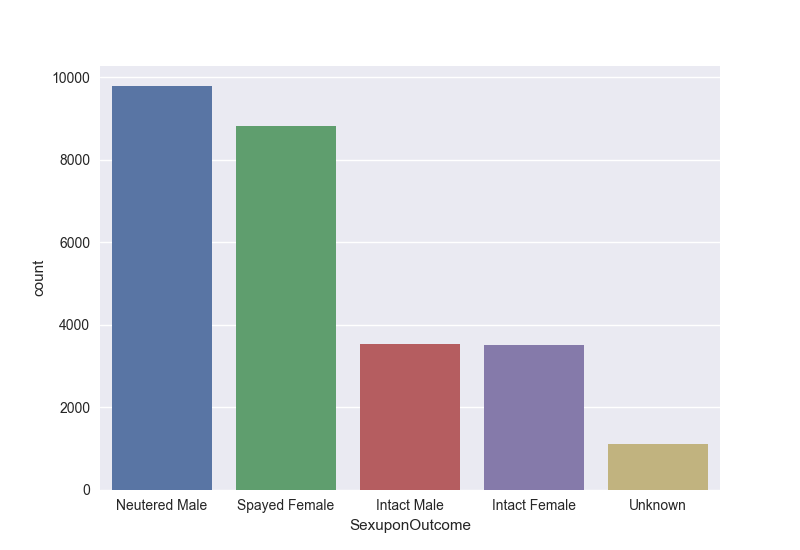

Neutered Male    9779
Spayed Female    8820
Intact Male      3525
Intact Female    3511
Unknown          1093
Name: SexuponOutcome, dtype: int64

In [21]:
figure()                                                   # Openning a new figure
sns.countplot(train_data.SexuponOutcome);                  # Plot the data
train_data.SexuponOutcome.value_counts()                   # Showing all values + how many of them

The following code snippet prints the unique elements of this feature.

In [22]:
print 'Elements = ', train_data.SexuponOutcome.unique()
print 'number of unique elemenets = ', len(train_data.SexuponOutcome.unique())

Elements =  ['Neutered Male' 'Spayed Female' 'Intact Male' 'Intact Female' 'Unknown'
 nan]
number of unique elemenets =  6


Based upon the above information we can divide our data into males and females, with or without intact sex organs, or not know. While there also seems to be $nan$ values we did not see them on the histogram we will group them along with the unknown values.

The next code segments defines functions for determing the sex and whether an animal is neutered (Called sapyed for females) or not. Followed by appling these features to the training set.

In [23]:
def getSex(s):
    '''For seperating sex. Male, Female, Unknown.'''
    s = str(s)
    if 'Male'  in s: return 'Male'
    if 'Female'in s: return 'Female'
    return 'Unknown'

def getNeutered(s):
    '''For seperating data into Intact, Neutered, and Unknown.'''
    s = str(s)
    if 'Spayed'  in s: return 'Neutered'
    if 'Neutered'in s: return 'Neutered'
    if 'Intact'  in s: return 'Intact'
    return 'Unknown'

In [24]:
train_data['Sex']         = train_data.SexuponOutcome.apply(getSex)     # Seperates into male & female & Unknown.
train_data['Neutered']    = train_data.SexuponOutcome.apply(getNeutered)# Seperates into Neutered & Intact.

In [25]:
# Vectorizing feature Sex
train_data['Male']        = pd.get_dummies(train_data['Sex'])['Male']
train_data['Female']      = pd.get_dummies(train_data['Sex'])['Female']
train_data['Sex_Unknown'] = pd.get_dummies(train_data['Sex'])['Unknown']

In [26]:
# Vectorizing feature Neutered
train_data['Intact']      = pd.get_dummies(train_data['Neutered'])['Intact']
train_data['Neuter']      = pd.get_dummies(train_data['Neutered'])['Neutered']
train_data['Neu_Unknown'] = pd.get_dummies(train_data['Neutered'])['Unknown']

We can now look at the distribution of animals we have based upon these features. We an also see the distribution based upon the outcome types.

<IPython.core.display.Javascript object>


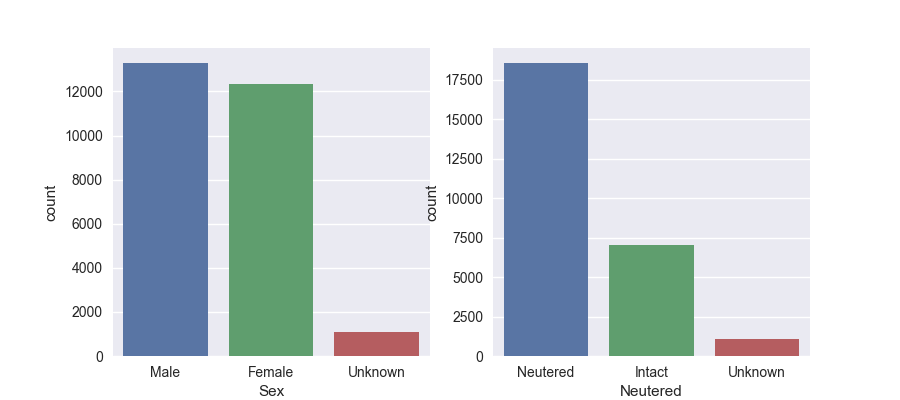

Male       13304
Female     12331
Unknown     1094
Name: Sex, dtype: int64
Neutered    18599
Intact       7036
Unknown      1094
Name: Neutered, dtype: int64


In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (9, 4))          # Makes 2 seperated plot object with the given size.
sns.countplot(train_data.Sex, ax = ax1);                      # Plot the data
sns.countplot(train_data.Neutered, ax = ax2);                 # Plot the data  
print (train_data.Sex.value_counts())                         # Showing all values + how many of them
print (train_data.Neutered.value_counts())                    # Showing all values + how many of them

<IPython.core.display.Javascript object>


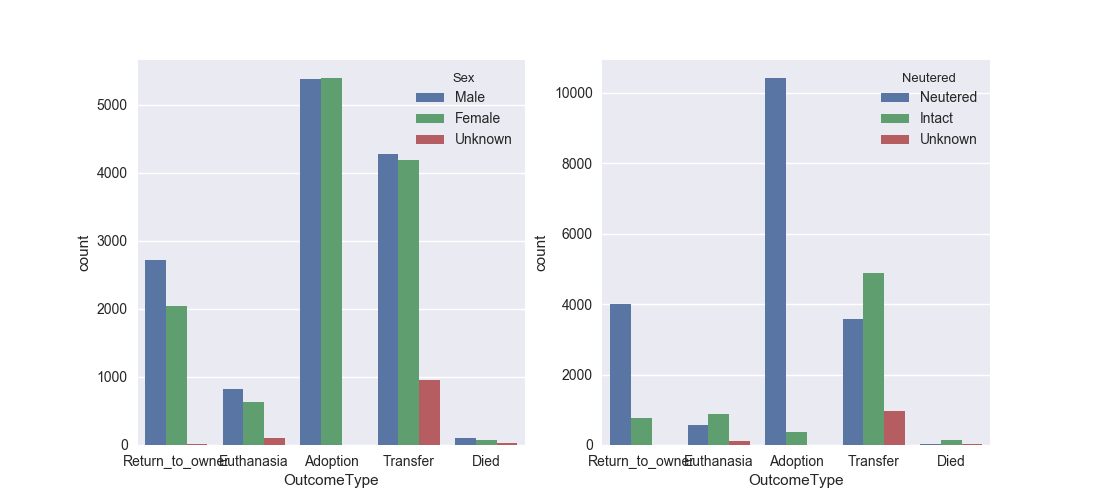

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 5))                             # Defining 2 plots
sns.countplot(data = train_data, x = 'OutcomeType',hue = 'Sex', ax = ax1);        # plot 1
sns.countplot(data = train_data, x = 'OutcomeType',hue = 'Neutered', ax = ax2);   # plot 2

We can see that the number of females and males are close while the number of unknow is relatively small. Based upon the outcomes we see sex doesnt really have a preference apart from unknowns being most likely transfered. However, neutering creates a drastic split, almost all adopted animals are neurtered, or returned to their owner, while intact animals are extremely likely to be transfered. Similarly to the sex outcomes, animals with unknon neurtered status are mainly transfered with the second most being euthanasia. 

So based upon this we can see that the distiction between male and female animals at this level does not seem to divide our data. However, the neutered features creates some clear distinctions in our data, which should make our predictions more accurate. 

As we have done before, we also apply this to our test data.

In [29]:
test_data['Sex']         = train_data.SexuponOutcome.apply(getSex)     # Seperates into male & female & Unknown.
test_data['Neutered']    = train_data.SexuponOutcome.apply(getNeutered)# Seperates into Neutered & Intact.

# Vectorizing feature Sex
test_data['Male']        = pd.get_dummies(test_data['Sex'])['Male']
test_data['Female']      = pd.get_dummies(test_data['Sex'])['Female']
test_data['Sex_Unknown'] = pd.get_dummies(test_data['Sex'])['Unknown']

# Vectorizing feature Neutered
test_data['Intact']      = pd.get_dummies(test_data['Neutered'])['Intact']
test_data['Neuter']      = pd.get_dummies(test_data['Neutered'])['Neutered']
test_data['Neu_Unknown'] = pd.get_dummies(test_data['Neutered'])['Unknown']

### Age Upon Outcome
Moving on to our next input feature, *Age Upon Outcome*, we will look at how this divides our data. The next code snippet plots a histogram of the input feature values.

<IPython.core.display.Javascript object>


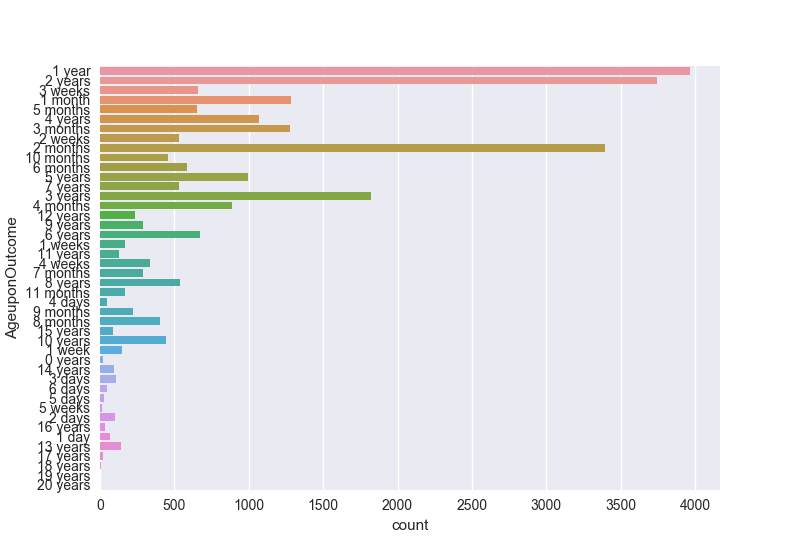

('number of unique elements = ', 45)


array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

In [30]:
figure()                                                 # Openning a new figure
sns.countplot(y = train_data.AgeuponOutcome);            # Plot the data
print ('number of unique elements = ', len(train_data.AgeuponOutcome.unique()))
train_data.AgeuponOutcome.unique()                       # Showing all unique values

This feature's data is much more unorginized than our previous features. From the unique elements we can see that we have a variety of scales utilized, days, months, and years. Since days seems to be our smallest division we will break our features into days of time. The next code block defines a function to conver our input into a number of days. Followed by a histogram of the resulting conversion.

In [31]:
def getAgesInDays(s):
    ''' This Method change the given value into the days.'''
    s = str(s)
    if s == 'nan': return np.nan
    age = int(s.split()[0])
    if 'year' in s: return age * 365.
    if 'month'in s: return age * 30.
    if 'week' in s: return age * 7.
    if 'day'  in s: return age
    else: return np.nan

<IPython.core.display.Javascript object>


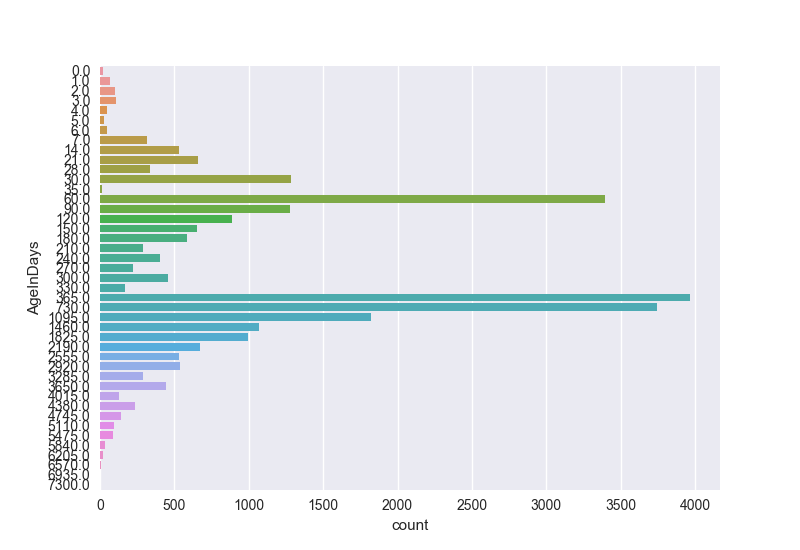

('number of unique elements = ', 44)


array([  3.65000000e+02,   7.30000000e+02,   2.10000000e+01,
         3.00000000e+01,   1.50000000e+02,   1.46000000e+03,
         9.00000000e+01,   1.40000000e+01,   6.00000000e+01,
         3.00000000e+02,   1.80000000e+02,   1.82500000e+03,
         2.55500000e+03,   1.09500000e+03,   1.20000000e+02,
         4.38000000e+03,   3.28500000e+03,   2.19000000e+03,
         7.00000000e+00,   4.01500000e+03,   2.80000000e+01,
         2.10000000e+02,   2.92000000e+03,   3.30000000e+02,
         4.00000000e+00,   2.70000000e+02,   2.40000000e+02,
         5.47500000e+03,   3.65000000e+03,   0.00000000e+00,
         5.11000000e+03,   3.00000000e+00,   6.00000000e+00,
         5.00000000e+00,   3.50000000e+01,   2.00000000e+00,
         5.84000000e+03,   1.00000000e+00,   4.74500000e+03,
                    nan,   6.20500000e+03,   6.57000000e+03,
         6.93500000e+03,   7.30000000e+03])

In [32]:
figure()
train_data['AgeInDays'] = train_data.AgeuponOutcome.apply(getAgesInDays) # (APX) Returns age as days
sns.countplot(y = train_data.AgeInDays);                                 # Plot the data
print ('number of unique elements = ', len(train_data.AgeInDays.unique()))
train_data.AgeInDays.unique()                                            # Showing all unique values)

We can see that the distribution is extremely non-uniform, we also have $nan$ values in our data. To adress the $nan$ values, since there are very few, we will replace them with the median of the data set. While this does modify the training data, the size of the $nan$ values in this feature is small enough that his change should be negligable. Now to combat the nonuniformity we will group regions of our data corresponding to the age of the animal. 

The following code blocks adress the $nan$ issue followed by grouping the ages into ranges of Puppy, Adolescent, Young, Adult, and Senior. Finally a histogram is shown showing how this grouping divides our data.

In [33]:
# Lets impute the missing values with median value
train_data.loc[(train_data['AgeInDays'].isnull()),'AgeInDays'] = train_data['AgeInDays'].median()

<IPython.core.display.Javascript object>


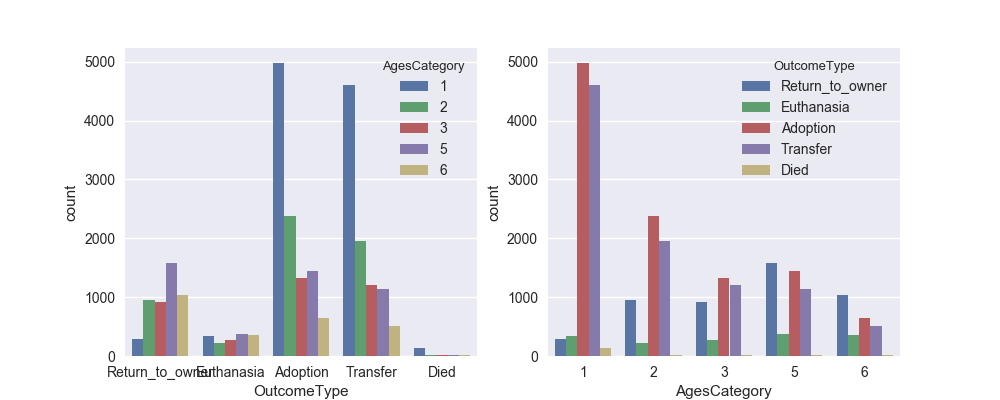

In [34]:
def AgesCategory(x):
    x = int(x)
    if x <= 180 : return 1                # Puppy
    if (x > 180) & (x <= 365) : return 2  # Adolescent
    if (x > 365) & (x <= 730) : return 3  # Young
    if (x > 730) & (x <= 2190): return 5  # Adult
    return 6                              # Senior

train_data['AgesCategory'] = train_data.AgeInDays.apply(AgesCategory)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))                                 # Defining 2 plots
sns.countplot(data = train_data, x = 'OutcomeType',hue = 'AgesCategory', ax = ax1);   # plot 1
sns.countplot(data = train_data, x = 'AgesCategory',hue = 'OutcomeType', ax = ax2);   # plot 2

We can see that as age increases adoption and transfer rates decrease. Which makes sense as many individuals looking for a pet would like one that will be with them for a long time, as well as transfering younger animals will help meet his demand elsewhere. On the other side the return to owner outcome is quite popular with adult animals and somewhat senior animals, this is caused potentially as animals age the are left at the shelter for health reasons.

Here we apply the above process to the test data. 

In [35]:
test_data['AgeInDays'] = test_data.AgeuponOutcome.apply(getAgesInDays) # (APX) Returns age as days

#Lets impute the missing values with median value
test_data.loc[(test_data['AgeInDays'].isnull()),'AgeInDays'] = test_data['AgeInDays'].median()
test_data['AgesCategory'] = test_data.AgeInDays.apply(AgesCategory)

### Breed
The next feature we will look at is *Breed*, the folloing code snippet displays the unique elements of this feature.

In [36]:
print ('number of unique elements = ', 
       len(train_data.Breed.unique()))              # Print the number of unique elements
print(train_data.Breed.value_counts().head(15))     # Print value_counts()

('number of unique elements = ', 1380)
Domestic Shorthair Mix       8810
Pit Bull Mix                 1906
Chihuahua Shorthair Mix      1766
Labrador Retriever Mix       1363
Domestic Medium Hair Mix      839
German Shepherd Mix           575
Domestic Longhair Mix         520
Siamese Mix                   389
Australian Cattle Dog Mix     367
Dachshund Mix                 318
Boxer Mix                     245
Miniature Poodle Mix          233
Border Collie Mix             229
Australian Shepherd Mix       163
Rat Terrier Mix               157
Name: Breed, dtype: int64


We can see that we have 1380 differnt types of animals in this data. While we could pass a boolean value for each type of potential breed (As in one of our first attempts), this results in a very large number of features resulting in much longer runtimes. So instead we group the breeds into grouping, the following code sections define our dog breed groups.

In [37]:
Companion_Dogs = ['Affenpinscher', 'American Eskimo Dog', 'Bichon Frise', 'Bolognese', 
'Boston Terrier', 'Brussels Griffon', 'BulldogBulldog',
'Cavalier King Charles Spaniel', 'Chihuahua' , 'Chinese Crested', 'Coton de Tulear', 'Dalmatian', 
'English Toy Spaniel', 'French Bulldog', 'Havanese', 'Italian Greyhound', 'Japanese Chin', 'Keeshond',
'Lhasa Apso', 'Lowchen', 'Maltese', 'Miniature Pinscher', 'Papillon', 'Pekingese', 'Pomeranian', 'Poodle',
'PugPug', 'Schipperke', 'Shiba Inu', 'Shih Tzu', 'Silky Terrier', 'Tibetan Spanie', 'Tibetan Terrier', 
'Toy Fox Terrier', 'Xoloitzcuintli', 'Yorkshire Terrier', 'Miniature Poodle']

Companion_Dogs = [Companion_Dogs[i].lower() for i in range(len(Companion_Dogs))]

In [38]:
Herding_Dogs = ['Appenzeller Sennenhunde', 'Australian Cattle Dog', 'Australian Cattle Dog', 'Australian Shepherd', 'Bearded Collie',
'Belgian Malinois', 'Belgian Sheepdog', 'Belgian Tervuren', 'Berger Picard', 'Border Collie', 
'Bouvier des Flandres', 'Briard', 'Canaan Dog', 'Cardigan Welsh Corgi', 'Catahoula Leopard Dog', 'Collie',
'Entlebucher Mountain Dog', 'Finnish Lapphund', 'German Shepherd Dog', 'Icelandic Sheepdog', 
'Lancashire Heeler', 'Norwegian Buhund', 'Pembroke Welsh Corgi', 'Polish Lowland Sheepdog','Puli', 
'Pyrenean Shepherd', 'Shetland Sheepdog', 'Swedish Vallhund', 'Collie Smooth']

Herding_Dogs = [ Herding_Dogs[i].lower() for i in range(len(Herding_Dogs))]

In [39]:
Hound_Dogs = [ 'Afghan Hound', 'American English Coonhound', 'American Foxhound', 'Azawakh', 'Basenji', 
'Basset Hound', 'Beagle', 'Black and Tan Coonhound', 'Bloodhound', 'Bluetick Coonhound', 'Borzoi', 
'Dachshund', 'English Foxhound', 'Greyhound', 'Harrier', 'Ibizan Hound', 'Irish Wolfhound', 
'Norwegian Elkhound', 'Otterhound', 'Petit Basset Griffon Vendeen', 'Pharaoh Hound', 'Plott', 'Pocket Beagle', 
'Redbone Coonhound', 'Rhodesian Ridgeback', 'Saluki', 'Scottish Deerhound', 'Sloughi', 
'Treeing Tennessee Brindle', 'Treeing Walker Coonhound', 'Whippet', 'Black Mouth Cur', 'Dogo Argentino']

Hound_Dogs = [ Hound_Dogs[i].lower() for i in range(len(Hound_Dogs))]

In [40]:
Hybrid_Dogs = ['Cockapoo', 'Goldador', 'Goldendoodle', 'Labradoodle', 'Maltese Shih Tzu', 'Maltipoo',
'Peekapoo', 'Puggle', 'Schnoodle', 'Yorkipoo']

Hybrid_Dogs = [ Hybrid_Dogs[i].lower() for i in range(len(Hybrid_Dogs))]

In [41]:
Mixed_Breed_Dogs = ['Bernedoodle', 'Mutt', 'Pomsky']

Mixed_Breed_Dogs = [ Mixed_Breed_Dogs[i].lower() for i in range(len(Mixed_Breed_Dogs))]

In [42]:
Sporting_Dogs = ['American Water Spaniel', 'Barbet', 'Boykin Spaniel', 'Bracco Italiano', 'Brittany', 
'Chesapeake Bay Retriever', 'Chesa Bay Retr','Clumber Spaniel', 'Cocker Spaniel', 'Curly Coated Retriever', 
'Curly Coat Retriever','English Cocker Spaniel', 'English Setter', 'English Springer Spaniel', 'Field Spaniel',
'Finnish Spitz', 'Flat Coated Retriever', 'Flat Coat Retriever', 'German Shorthaired Pointer',
'German Wirehaired Pointer', 'Golden Retriever', 'Gordon Setter', 'Irish Red and White Setter', 
'Irish Setter', 'Irish Water Spaniel', 'Kooikerhondje', 'Korean Jindo Dog', 'Labrador Retriever', 
'Nova Scotia Duck Tolling Retriever', 'Pointer', 'Small Munsterlander Pointer', 'Stabyhoun', 
'Sussex Spaniel', 'Vizsla', 'Weimaraner', 'Welsh Springer Spaniel', 'Wirehaired Pointing Griffon',
'English Pointer']

Sporting_Dogs = [ Sporting_Dogs[i].lower() for i in range(len(Sporting_Dogs))]

In [43]:
Terrier_Dogs = ['Airedale Terrier', 'American Pit Bull Terrier', 'Australian Terrier', 'Bedlington Terrier', 
'Border Terrier', 'Bull Terrier', 'Cairn Terrier', 'Cesky Terrier', 'Dandie Dinmont Terrier', 
'Fox Terrier', 'Glen of Imaal Terrier', 'Irish Terrier', 'Jack Russell Terrier', 'Kerry Blue Terrier', 
'Lakeland Terrier', 'Manchester Terrier', 'Miniature Schnauzer', 'Norfolk Terrier', 'Norwich Terrier', 
'Rat Terrier', 'Scottish Terrier', 'Sealyham Terrier', 'Skye Terrier', 'Soft Coated Wheaten Terrier', 
'Staffordshire Bull Terrier', 'Welsh Terrier', 'West Highland White Terrier']

Terrier_Dogs = [ Terrier_Dogs[i].lower() for i in range(len(Terrier_Dogs))]

In [44]:
Working_dogs = ['Bernese Mountain Dog', 'Black Russian Terrier', 'Boxer', 'Bullmastiff', 'Cane Corso', 
'Chinese Shar-Pei', 'Chinook', 'Chow Chow', 'Doberman Pinscher', 'Dogue de Bordeaux', 'German Pinscher', 
'Giant Schnauzer', 'Great Dane', 'Great Pyrenees', 'Greater Swiss Mountain Dog', 'Komondor', 'Kuvasz', 
'Leonberger', 'Mastiff', 'Neapolitan Mastiff', 'Newfoundland', 'Norwegian Lundehund', 'Portuguese Water Dog', 
'Rottweiler', 'Saint Bernard', 'Samoyed', 'Siberian Husky', 'Standard Schnauzer', 'Tibetan Mastiff', 
'Blue Lacy', 'Anatol Shepherd', 'Australian Kelpie Dog', 'Australian Kelpie']

Working_dogs = [ Working_dogs[i].lower() for i in range(len(Working_dogs))]
Breed_Dogs = ['Working_dogs', 'Terrier_Dogs', 'Sporting_Dogs', 'Mixed_Breed_Dogs', 'Hybrid_Dogs',
             'Hound_Dogs', 'Herding_Dogs', 'Companion_Dogs']

This next code section defines functions for determining the which groupings a given dog falls into.

In [45]:
def breedDogs(x):
    x = str(x).lower()
    isList = 0
    if '/' in x:
        x = x.split('/')
        isList = 1
    if isList:
        for i in x:
            return find_breed(i)
    else: 
        return find_breed(x)

def find_breed(x):
    x = str(x).lower()
    if '-' in x:
        replace("-", " ")
    if str(x).endswith('mix'):
        x = x[:-4]
    if str(x).endswith('dog'):
        x = x[:-4]
    if str(x).endswith('dogs'):
        x = x[:-5]
    if str(x).endswith('shorthair'):
        x = x[:-10]
    if str(x).endswith('longhair'):
        x = x[:-9]
    if str(x).endswith('hound'):
        x = x[:-6]
    if str(x).endswith('heeler'):
        x = 'heeler'
    if str(x).startswith('american'):
        if x != 'american':
            x = x[9:]
    if 'staffordshire' in x:
        x = 'staffordshire'
    if 'german shepherd' in x:
        x = 'german shepherd'
    for el in Companion_Dogs:
        if x in el  : return 'Companion_Dogs'
    for el in Herding_Dogs:
        if x in el  : return 'Herding_Dogs'
    for el in Hound_Dogs:
        if x in el  : return 'Hound_Dogs'
    for el in Hybrid_Dogs:
        if x in el  : return 'Hybrid_Dogs'
    for el in Mixed_Breed_Dogs:
        if x in el  : return 'Mixed_Breed_Dogs'
    for el in Sporting_Dogs:
        if x in el  : return 'Sporting_Dogs'
    for el in Terrier_Dogs:
        if x in el  : return 'Terrier_Dogs'
    for el in Working_dogs:
        if x in el  : return 'Working_dogs'
    return np.nan  # For now, we just going to return Null. Later we will take care of Null values.

Now that we can apply this to our training data.

In [46]:
# Preparing trainings
print ('start vectorizing...')               # Showing message at the begining of vectorization.                
train_data['Breed_Dogs'] = zeros(len(train_data))
train_data['Breed_Dogs'] = train_data.Breed.apply(breedDogs)
dummies = pd.get_dummies(train_data.Breed_Dogs)  # Make a dummies
for dum in dummies.columns.values:
    train_data[dum] = dummies[dum]
print ('Done!...')                           # Showing message at the end.

start vectorizing...
Done!...


Since we have applied the groupings to our training data we can now look at the histograms for each grouping.

<IPython.core.display.Javascript object>


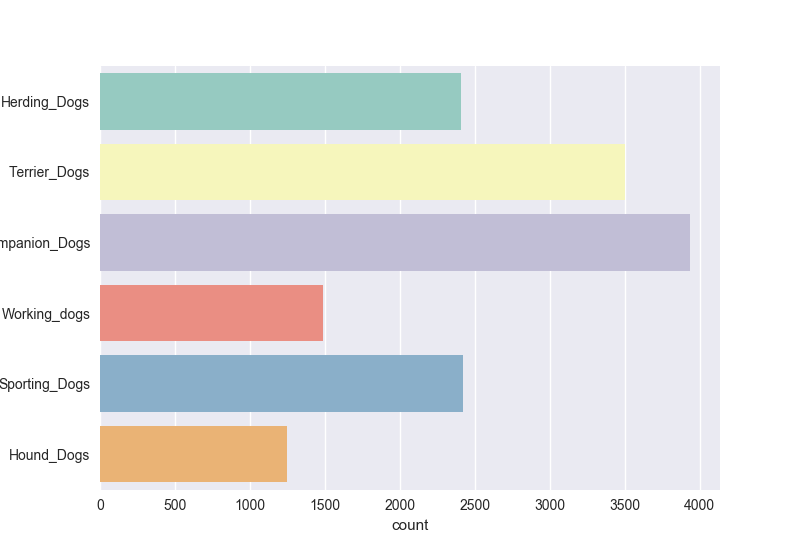

In [48]:
figure()                                               # Openning a new figure 
sns.countplot(y = train_data.Breed_Dogs, palette='Set3'); # Plot the data

<IPython.core.display.Javascript object>


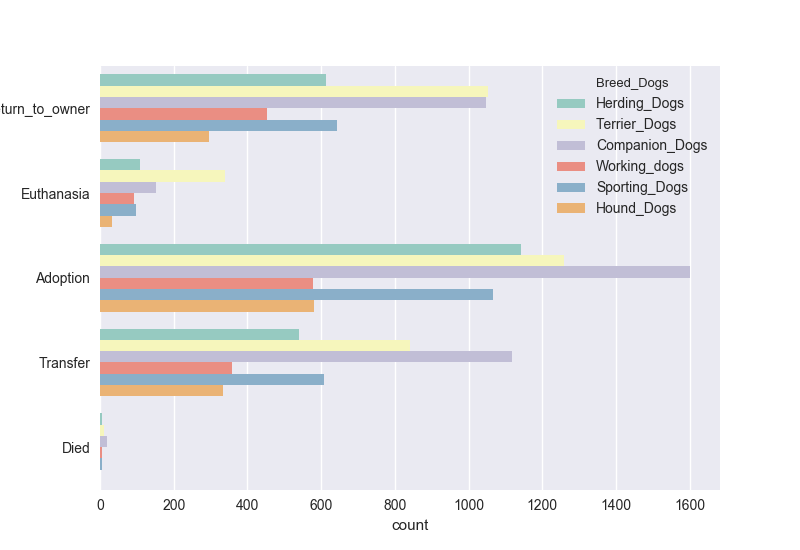

<IPython.core.display.Javascript object>


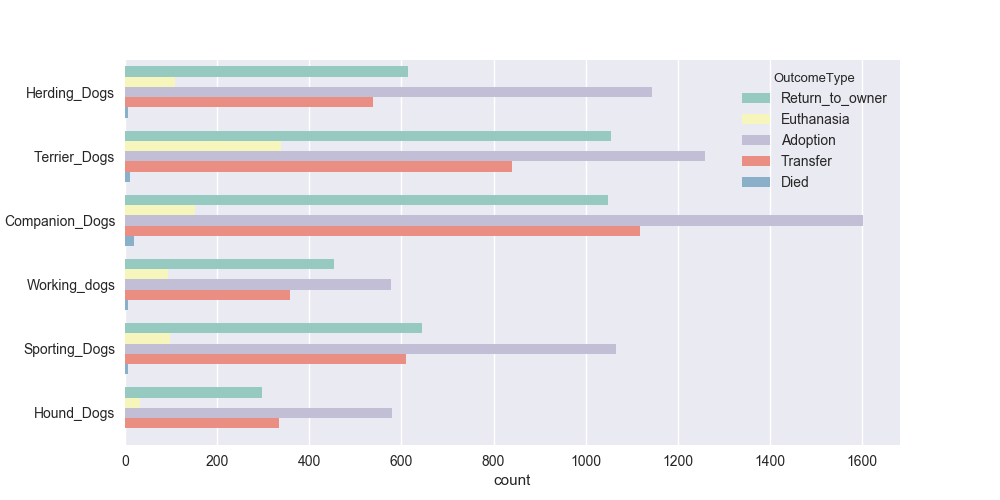

In [49]:
figure()
figsize(10,5)
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'Breed_Dogs', palette='Set3'); # plot 1
figure()
sns.countplot(data = train_data, y = 'Breed_Dogs',hue = 'OutcomeType', palette='Set3'); # plot 2

We can see that dividing with this grouping creates a similar information, however each grouping has a different distribution on the outcome type. By converting breeds we have reduced the amount of features passed to the machine learning classifer significatly. 

Now we will do the same process with cats.

In [50]:
Russia_Cats = ['Kurilian Bobtail', 'Siberian', 'Russian Blue', 'Peterbald', 'Mekong Bobtail', 'Donskoy', 
               'Don Sphynx', 'Kurilian Bobtail']
Russia_Cats = [ Russia_Cats[i].lower() for i in range(len(Russia_Cats))]
US_Cats = ['Himalayan', 'Toyger', 'Snowshoe', 'Serengeti', 'Selkirk Rex', 'Savannah', 'Ragdoll', 'Ragamuffin', 
          'Pixie-bob', 'Pixiebob', 'Pixie bob','Oregon Rex', 'Ojos Azules', 'Ocicat', 'Nebelung', 'Munchkin', 'Minskin', 'Maine Coon', 
          'Lykoi', 'LaPerm', 'Javanese', 'Highlander', 'Exotic Shorthair', 'Cheetoh', 'Chantilly-Tiffany'
          , 'California Spangled', 'Bambino', 'American Wirehair', 'American Shorthair', 'American Curl',
           'Domestic Shorthair', 'Domestic Longhair', 'Domestic Medium Hair', 'Domestic'
          'American Bobtail', 'Balinese', 'Bombay', 'Bombay', 'Bengal', 'Turkish Van', 'Asian', 'York Chocolate']
US_Cats = [ US_Cats[i].lower() for i in range(len(US_Cats))]
England_Cats = ['Scottish Fold', 'Manx', 'Cymric', 'Manx Longhair', 'Devon Rex', 'Cornish Rex', 'Havana Brown', 
                'Burmilla', 'Burmilla', 'British Shorthair', 'British Semi-longhair', 'British Longhair', 
               'Asian Semi-longhair', 'Asian Semilonghair', 'Asian Semi longhair']
England_Cats = [ England_Cats[i].lower() for i in range(len(England_Cats))]
Ukrain_Cats = ['ukrainian levkoy']
Turky_Cats = ['turkish angora']
Thailand_Cats = ['thai lilac', 'thai', 'suphalak', 'siamese', 'sam sawet', 'korn ja', 'korat', 'khao manee', 
                'somali', 'singapura','burmese',  ]
Norway_Cats = ['norwegian forest']
Korea_Cats = ['korean bobtail']
Kenya_Cats = ['sokoke']
Japan_Cats = ['japanese bobtail']
Persian_Cats = ['persian']
Indonesia_Cats = ['raas']
Greece_Cats = ['aegean']
France_Cats = ['serrade petit', 'chausie', 'chartreux', 'birman', ]
Finland_Sweden_Cats = ['european shorthair']
Europ_Cats = ['perfold']
ethiopia_Cats = ['abyssinian']
Egypt = ['egyptian mau']
Germany = ['german rex']
Cyprus = ['cyprus']
China_Cats = ['aragon li']
Canada_Cats = ['tonkinese', 'sphynx', 'foldex', ]
Brazil_Cats = ['brazilian shorthair']
Australia_Cats = ['russian white, black and tabby', 'australian mist']
Arabian_Cats = ['arabian mau']
Cats_categories = ['Russia_Cats', 'US_Cats', 'England_Cats', 'Ukrain_Cats', 'Turky_Cats', 'Thailand_Cats',
                 'Norway_Cats', 'Korea_Cats', 'Kenya_Cats', 'Japan_Cats', 'Persian_Cats', 'Indonesia_Cats',
                 'Greece_Cats', 'France_Cats', 'Finland_Sweden_Cats', 'Europ_Cats', 'ethiopia_Cats', 
                 'Egypt', 'Germany', 'Cyprus', 'China_Cats', 'Canada_Cats', 'Brazil_Cats',
                 'Australia_Cats', 'Arabian_Cats']
Cats_categories = [ Cats_categories[i].lower() for i in range(len(Cats_categories))]

In [51]:
def breedCats(x):
    x = str(x).lower()
    isList = 0
    if '/' in x:
        x = x.split('/')
        isList = 1
    if isList:
        for i in x:
            return findC(i)
    else: return findC(x)
    
def findC(x):
    x = str(x).lower()
    if str(x).endswith('mix'):
        x = x[:-4]
    if str(x).endswith('cat'):
        x = x[:-4]
    if str(x).endswith('cats'):
        x = x[:-5]
    for el in US_Cats:
        if x in el  : return 'US_Cats'
    for el in Russia_Cats:
        if x in el  : return 'Russia_Cats'
    for el in Thailand_Cats:
        if x in el  : return 'Thailand_Cats'
    for el in England_Cats:
        if x in el  : return 'England_Cats'
    for el in Ukrain_Cats:
        if x in el  : return 'Ukrain_Cats'
    for el in Turky_Cats:
        if x in el  : return 'Turky_Cats'
    for el in Norway_Cats:
        if x in el  : return 'Norway_Cats'
    for el in Korea_Cats:
        if x in el  : return 'Korea_Cats'
    for el in Kenya_Cats:
        if x in el  : return 'Kenya_Cats'
    for el in Japan_Cats:
        if x in el  : return 'Japan_Cats'
    for el in Persian_Cats:
        if x in el  : return 'Persian_Cats'
    for el in Indonesia_Cats:
        if x in el  : return 'Indonesia_Cats'
    for el in Greece_Cats:
        if x in el  : return 'Greece_Cats'
    for el in France_Cats:
        if x in el  : return 'France_Cats'
    for el in Finland_Sweden_Cats:
        if x in el  : return 'Finland_Sweden_Cats'
    for el in Europ_Cats:
        if x in el  : return 'Europ_Cats'
    for el in ethiopia_Cats:
        if x in el  : return 'ethiopia_Cats'
    for el in Egypt:
        if x in el  : return 'Egypt'
    for el in Germany:
        if x in el  : return 'Germany'
    for el in Cyprus:
        if x in el  : return 'Cyprus'
    for el in China_Cats:
        if x in el  : return 'China_Cats'
    for el in Canada_Cats:
        if x in el  : return 'Canada_Cats'
    for el in Brazil_Cats:
        if x in el  : return 'Brazil_Cats'
    for el in Australia_Cats:
        if x in el  : return 'Australia_Cats'
    for el in Arabian_Cats:
        if x in el  : return 'Arabian_Cats'
    return np.nan

In [52]:
# Preparing trainings
print ('start vectorizing...')               # Showing message at the begining of vectorization.                
train_data['Cat_categories'] = zeros(len(train_data))
train_data['Cat_categories'] = train_data.Breed.apply(breedCats)
dummies = pd.get_dummies(train_data.Cat_categories)  # Make a dummies
for dum in dummies.columns.values:
    train_data[dum] = dummies[dum]
print ('Done!...')                           # Showing message at the end.

start vectorizing...
Done!...


<IPython.core.display.Javascript object>


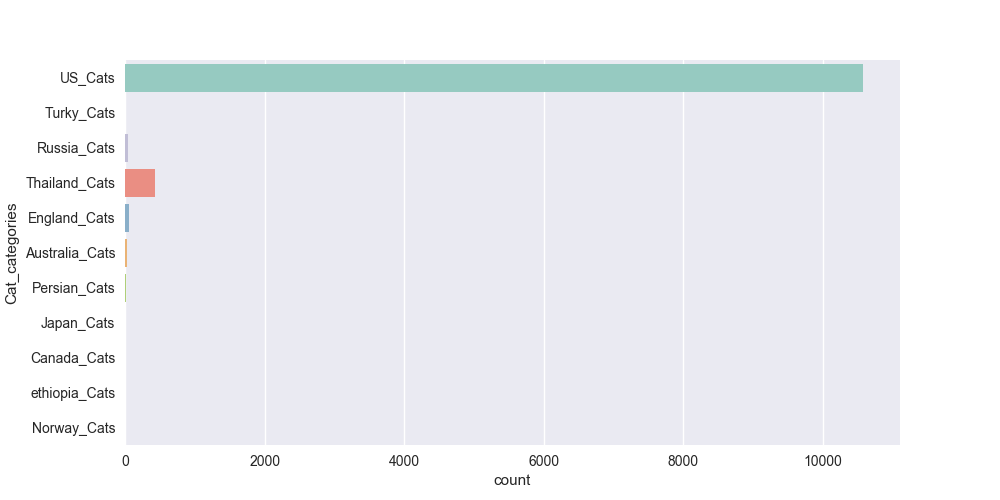

In [54]:
figure()                                               # Openning a new figure 
sns.countplot(y = train_data.Cat_categories, palette='Set3'); # Plot the data

<IPython.core.display.Javascript object>


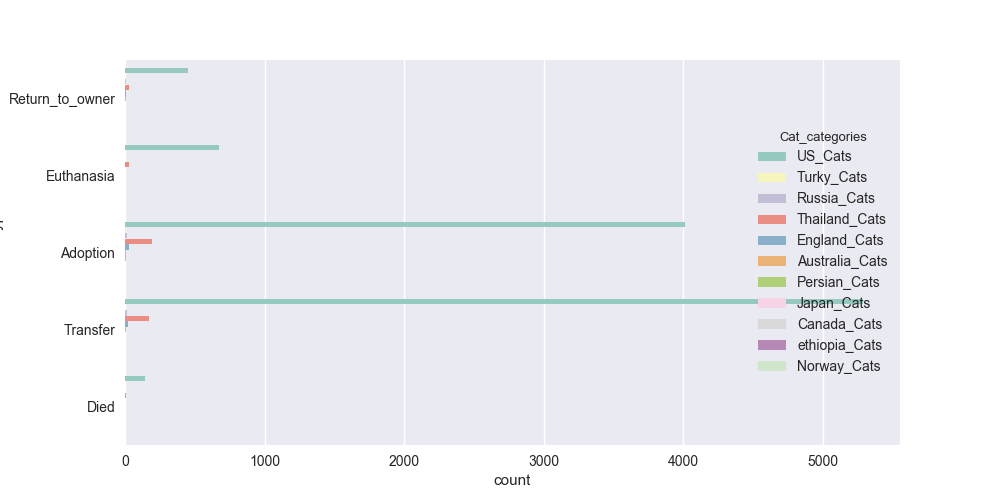

<IPython.core.display.Javascript object>


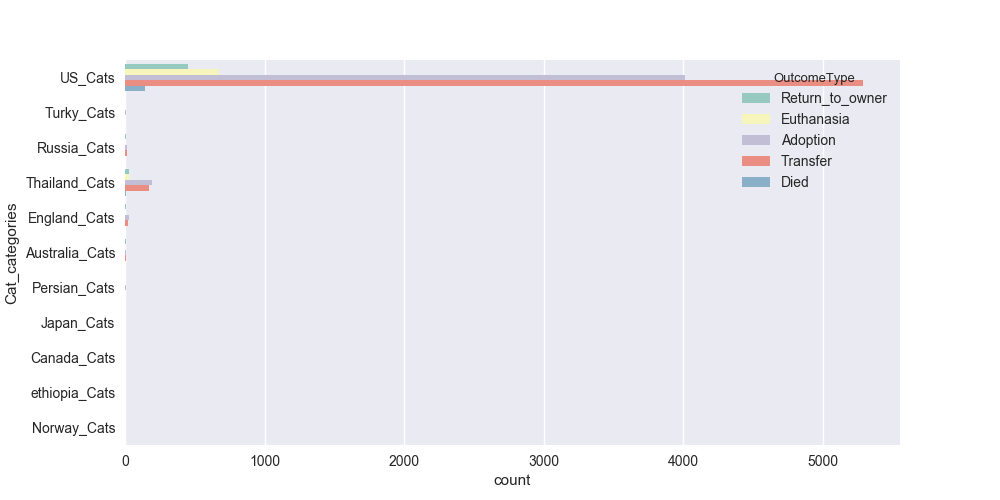

In [55]:
figure()
figsize(10,5)
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'Cat_categories', palette='Set3'); # plot 1
figure()
sns.countplot(data = train_data, y = 'Cat_categories',hue = 'OutcomeType', palette='Set3'); # plot 2

From the above data the divisions around cats was much less uniform than dogs, thus these features for cats may not impact the performance as much as classifing dog groupings.

Finally we apply the above process to our test data as well.

In [47]:
# Preparing Test data
print ('start vectorizing...')               # Showing message at the begining of vectorization.                
test_data['Breed_Dogs'] = zeros(len(test_data))
test_data['Breed_Dogs'] = test_data.Breed.apply(breedDogs)#
dummies = pd.get_dummies(test_data.Breed_Dogs)  # Make a dummies
for dum in dummies.columns.values:
    test_data[dum] = dummies[dum]
print ('Done!...')                           # Showing message at the end.

start vectorizing...
Done!...


In [53]:
# Preparing Test data
print ('start vectorizing...')               # Showing message at the begining of vectorization.                
test_data['Cat_categories'] = zeros(len(test_data))
test_data['Cat_categories'] = test_data.Breed.apply(breedCats)
dummies = pd.get_dummies(test_data.Cat_categories)  # Make a dummies
for dum in dummies.columns.values:
    test_data[dum] = dummies[dum]
print ('Done!...')                           # Showing message at the end.

start vectorizing...
Done!...


### Color
Lastly, we will look at the *Color* feature. The folowing code defines a function that removes modifiers on the colors of the animal.

In [56]:
def getColors(x):
    x = str(x).lower()
    if '/' in x:
        x = x.split('/')[0]
    if x in 'ruddy':
        x = 'brown'
    if x in 'orange tiger':
        x = 'orange'
    if x in 'black tiger':
        x = 'black'
    if x in 'brown tiger':
        x = 'brown'
    if x in 'liver tick':
        x = 'liver'
    return x

We now apply this to both our training and test data. Then plot the histogram of the various color values.

In [57]:
train_data['animal_colors'] = train_data.Color.apply(getColors)
test_data['animal_colors'] = test_data.Color.apply(getColors)

<IPython.core.display.Javascript object>


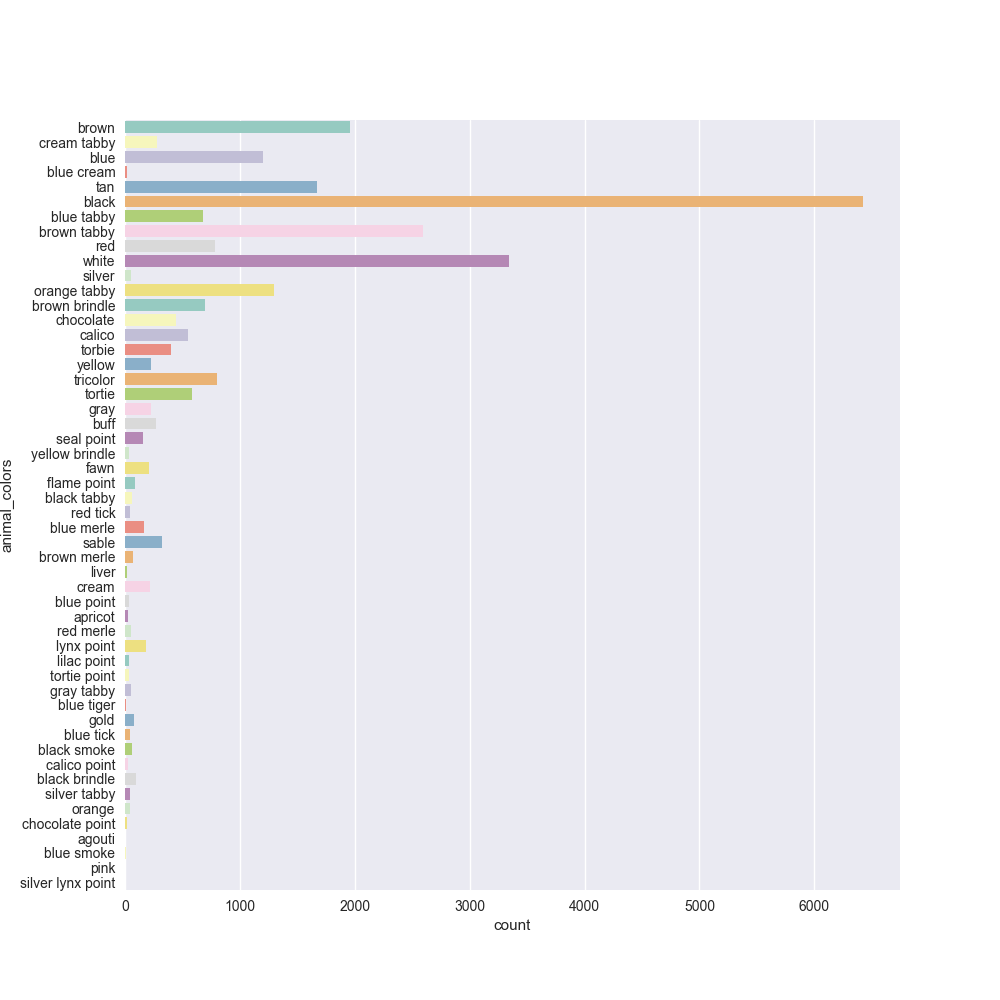

In [58]:
figsize(10,10)
figure()                                               # Openning a new figure 
sns.countplot(y = train_data.animal_colors, palette='Set3'); # Plot the data

<IPython.core.display.Javascript object>


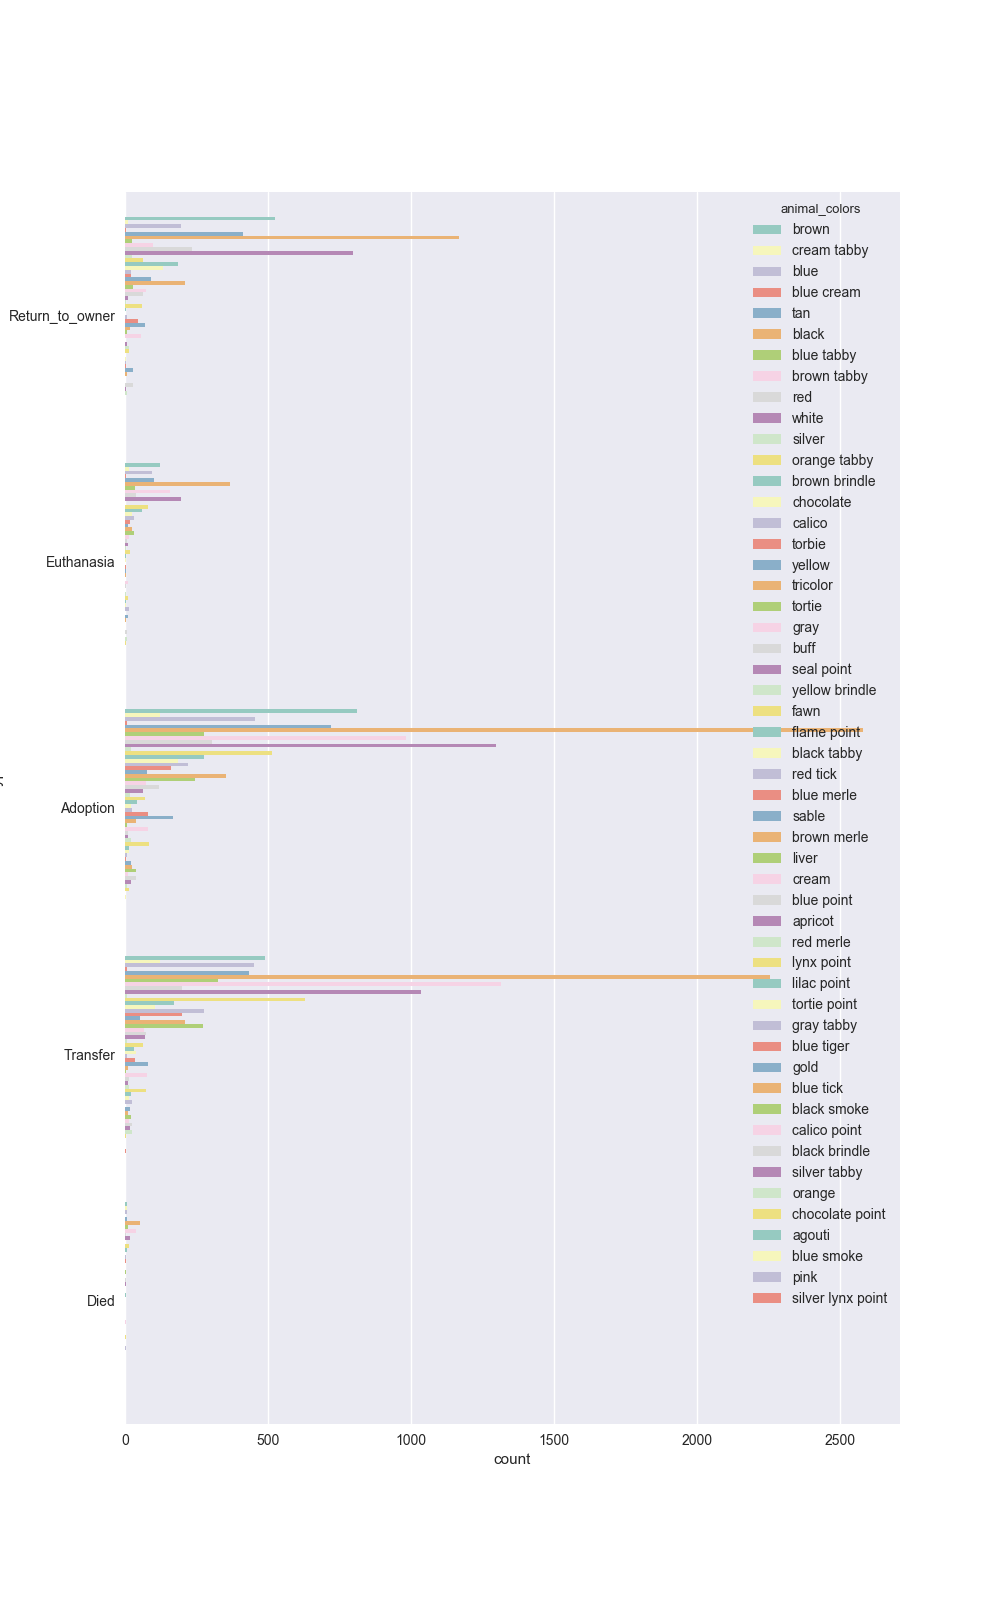

/Users/Meijad/anaconda2/envs/ser627a/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


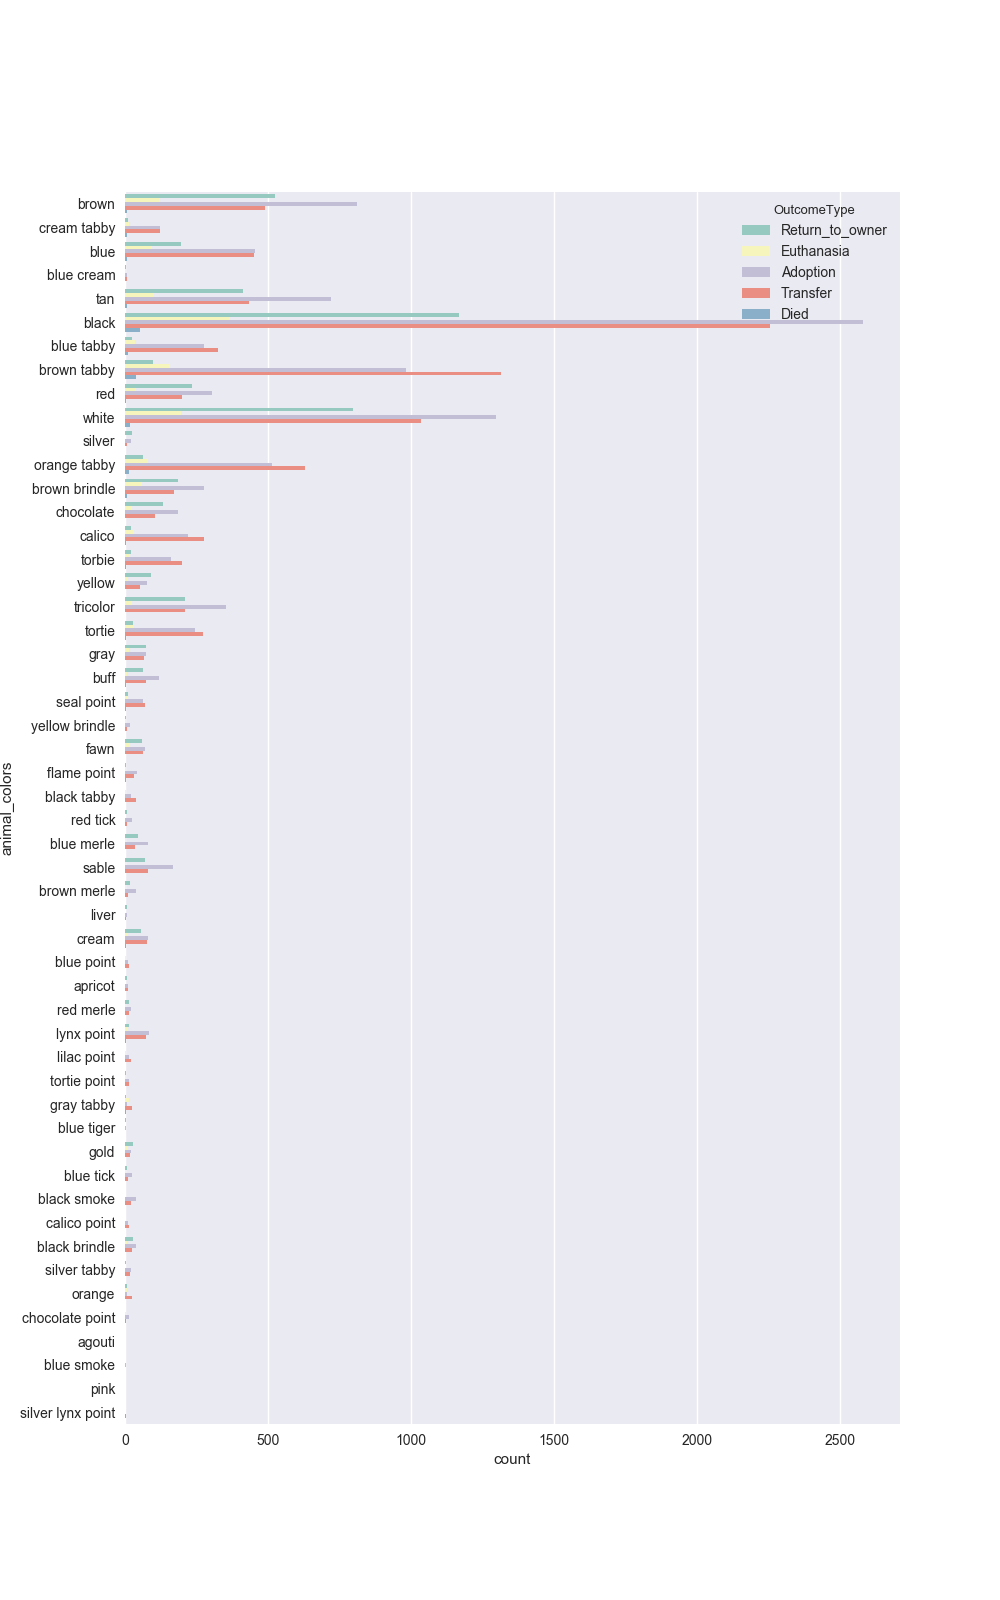

In [59]:
figsize(10,16)
figure()
sns.countplot(data = train_data, y = 'OutcomeType',hue = 'animal_colors', palette='Set3'); # plot 1
figure()
sns.countplot(data = train_data, y = 'animal_colors',hue = 'OutcomeType', palette='Set3'); # plot 2

Similar to the Breed, there are too many unique colors in this feature. So, we will do the same thing here as we did for the Breed. First, we produce only key-words that are repeated among all values to reduce the number of unique elements in the Color feature. Then, we will vectorize the color based on only those colors.


In [60]:
print ('start vectorizing...')              # Showing message at the begining of vectorization.
dummies = pd.get_dummies(train_data.animal_colors)
for dum in dummies:
    train_data[dum] = dummies[dum]          # Making featurs from dummies
print ('Done!...')                          # Showing message at the end.

start vectorizing...
Done!...


In [61]:
print ('start vectorizing...')              # Showing message at the begining of vectorization.
dummies = pd.get_dummies(test_data.animal_colors)
for dum in dummies:
    test_data[dum] = dummies[dum]          # Making featurs from dummies
print ('Done!...')                         # Showing message at the end.

start vectorizing...
Done!...


### Organizing
Now that we have competed the modifing our data we need to get rid of the features we have broken into smaller features. The next code blocks drop these various columns.

In [70]:
train_data.drop('DateTime', axis=1, inplace   = True) 
train_data.drop('Name', axis=1, inplace   = True) 
train_data.drop('OutcomeType', axis=1, inplace   = True) 
train_data.drop('OutcomeSubtype', axis=1, inplace   = True) 
train_data.drop('AnimalType', axis=1, inplace   = True) 
train_data.drop('SexuponOutcome', axis=1, inplace   = True) 
train_data.drop('AgeuponOutcome', axis=1, inplace   = True) 
train_data.drop('Breed', axis=1, inplace   = True) 
train_data.drop('Breed_Dogs', axis=1, inplace   = True)
train_data.drop('Cat_categories', axis=1, inplace   = True)
train_data.drop('Color', axis=1, inplace   = True) 
train_data.drop('Time', axis=1, inplace   = True) 
train_data.drop('Sex', axis=1, inplace   = True) 
train_data.drop('animal_colors', axis=1, inplace   = True) 
train_data.drop('Neutered', axis=1, inplace   = True) 

#train_data.head(15)

In [71]:
test_data.drop('Name', axis=1, inplace   = True) 
test_data.drop('DateTime', axis=1, inplace   = True)
test_data.drop('AnimalType', axis=1, inplace   = True)
test_data.drop('SexuponOutcome', axis=1, inplace   = True)
test_data.drop('AgeuponOutcome', axis=1, inplace   = True) 
test_data.drop('Breed', axis=1, inplace   = True) 
test_data.drop('Breed_Dogs', axis=1, inplace   = True)
test_data.drop('Cat_categories', axis=1, inplace   = True) 
test_data.drop('Color', axis=1, inplace   = True) 
test_data.drop('Time', axis=1, inplace   = True) 
test_data.drop('Sex', axis=1, inplace   = True)
test_data.drop('animal_colors', axis=1, inplace   = True)
test_data.drop('Neutered', axis=1, inplace   = True) 
#test_data.head(15)

Now we can see the shape of our data.

In [72]:
train_data.shape, test_data.shape
#train_data.iloc[0], 
#train_data.iloc[0]
#test_data
#Y_train

((26729, 87), (11456, 87))

We can see that we have expanded from our original 8 features to 87 different features, this hopefully allows us to predict the outcomes of the test data relatively well and relatively quickly.

Now we can look at the differences between the two sets.

In [73]:
set(train_data.columns.values) ^ set(test_data.columns.values)  # different column in train and test data

{'AnimalID', 'France_Cats', 'ID', 'Japan_Cats'}

It seems that from train to testing the AnimalID is changed to ID, as well as the training set has French cats, and no Japan cats, with the converse for test data. This is ok as those particular features should not effect the overall score too much.

Now we use a support vector machine (SVM), which finds support vectors based upon the input features. The support vectors describe hyperplanes that maximize the distance from the closes two points in a decision boundary. We found using a gama of 0.10000000000000001 to result in a better score. We train the SVM on the training data.

In [74]:
gma= 0.10000000000000001
svc = SVC( C = 1, gamma = gma, probability = True, random_state = 0)
print('Start fitting data...')
svc.fit(train_data.iloc[:,1:] , Y_train)
print('Done!')
Y_train.shape, train_data.shape



Start fitting data...
Done!


((26729,), (26729, 87))

Now we predict the probabilities of the test data using our trained SVM.

In [75]:
print('start predicting....')
Y_pred = svc.predict(test_data.iloc[:,1:])
P_prob = svc.predict_proba(test_data.iloc[:,1:])
print('Done!')

start predicting....
Done!


Finally, we output our submission file, using our predicted probabilites of the test data.

In [81]:
# Writing the result into a file
submission = pd.DataFrame({"ID": [],
                     "Adoption": [],
                         "Died": [],
                   "Euthanasia": [],
              "Return_to_owner": [],
                     "Transfer": []})
submission.ID = test_data.ID
submission.Adoption = P_prob[:,0]
submission.Died = P_prob[:,3]
submission.Euthanasia = P_prob[:,2]
submission.Return_to_owner = P_prob[:,3]
submission.Transfer = P_prob[:,4]
submission.to_csv("my_submission09.csv", index = False)